[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RichardPotthoff/Climate/blob/main/CO2.ipynb)

In [1]:
import os
if not os.path.exists('co2_mlo_surface-insitu_1_ccgg_DailyData.zip'):
  !wget https://raw.githubusercontent.com/RichardPotthoff/Climate/main/'co2_mlo_surface-insitu_1_ccgg_DailyData.zip'

In [2]:
from zipfile import ZipFile
import numpy as np
from matplotlib import pyplot as plt
import io
import ntpath
from contextlib import ExitStack

def read_data(filename='co2_mlo_surface-insitu_1_ccgg_DailyData.zip',fields=['time_decimal','value']):
  fn,ext=ntpath.splitext(filename)
  with ExitStack() as es:
    if ext.upper()=='.ZIP': 
      fz=es.enter_context(ZipFile(filename))
#      print(fz.namelist()) 
#      fz.printdir()
      fb=es.enter_context(fz.open(fz.namelist()[0]))# assumes that there is only one file
      f=es.enter_context(io.TextIOWrapper(fb,encoding='utf-8'))
    else:
      f=es.enter_context(open(filename,'r'))
    for line in f:
      if line[0]=='#':
        continue
      else:
        header=line
        break
    field_dict={field:i for i,field in enumerate(header.split())}
    i_fields=[field_dict.get(field,None) for field in fields]
    i=0
    i_max=-1
    for line in f:
        if line[0]=='#':
            continue
        values=line.split()
        field_values=[values[i] for i in i_fields]
        if field_values[1][0]!='-': 
            yield field_values
            i+=1
            if (i>i_max)and (i_max>=0):
                break

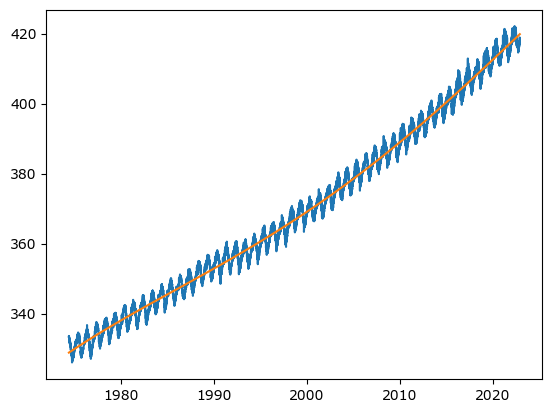

In [3]:
t,x_CO2=np.array(list(read_data(filename='co2_mlo_surface-insitu_1_ccgg_DailyData.zip',fields=['time_decimal','value'])),dtype=float).transpose()
plt.plot(t,x_CO2) 
deg=4
p=np.polyfit(t,x_CO2,deg)[::-1]#reverse the order of coefficients so that y(x)=sum(p_i*x^i)
plt.plot(t,sum(pi*t**i for i,pi in enumerate(p)));

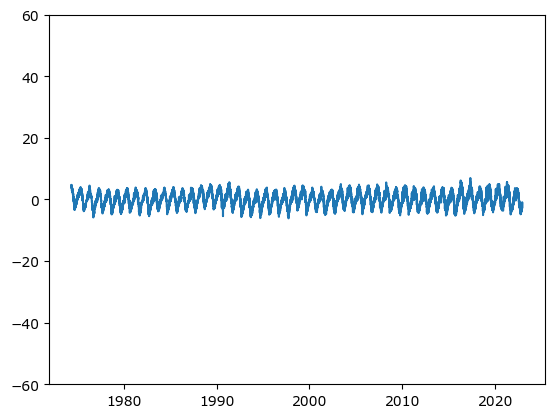

In [4]:
plt.plot(t,x_CO2-sum(pi*t**i for i,pi in enumerate(p)))   
plt.ylim(-60,60);

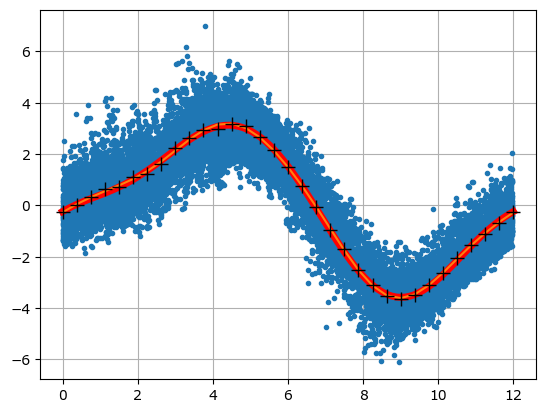

In [5]:
plt.plot(t%1*12,x_CO2-sum(pi*t**i for i,pi in enumerate(p)),'.')  
import scipy as sp
import cmath
n=32
csr=sp.sparse.csc_array((x_CO2-sum(pi*t**i for i,pi in enumerate(p)),(np.zeros(t.shape,dtype=int),np.array((((t+0.5/n)%1)*n)//1,dtype=int),)))
ncsr=sp.sparse.csc_array((np.ones(x_CO2.shape),(np.zeros(t.shape,dtype=int),np.array((((t+0.5/n)%1)*n)//1,dtype=int),)))
csr.sum_duplicates()
ncsr.sum_duplicates()
avg_CO2=csr.toarray()[0]/ncsr.toarray()[0]
plt.plot([(i)/n*12 for i in range(n+1)],avg_CO2[[i%n for i in range(n+1)]],'k+', ms=10,zorder=13)  
#plt.plot((0,12),(0,0),'k',zorder=11)
plt.grid()
f=np.fft.rfft(avg_CO2)
ff=f.copy()
ff[5:]=0.0
avg_CO2_filtered=np.fft.irfft(ff)
plt.plot([(i)/n*12 for i in range(n+1)],avg_CO2_filtered[[i%n for i in range(n+1)]],'-',zorder=12)  
t1=np.linspace(0,1.0,101)
plt.plot((t1)*12,sum(abs(f[i])*np.cos(2*np.pi*i*(t1)+cmath.phase(f[i]))for i in range(3+1))/n*2,'r-',lw=5,zorder=11);

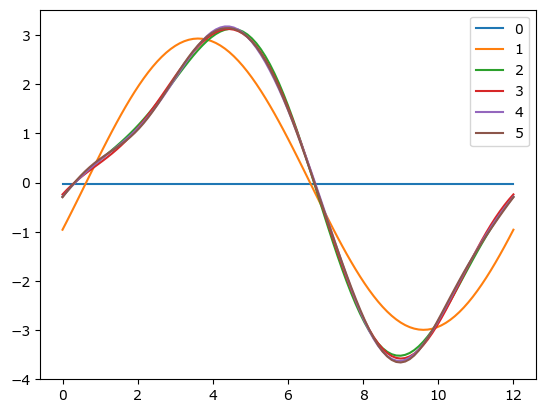

In [6]:
import cmath
abs(f[1])
cmath.phase(f[1])
t1=np.linspace(0.0,12.0,101) 
for n1 in range(6):
#  plt.plot(t1,abs(f[n1])*np.cos(2*np.pi*n1*t1/12+cmath.phase(f[n1]))/n*2)
#  plt.plot(t1,sum((abs(f[j])*np.cos(2*np.pi*j*t1/12+cmath.phase(f[j])) for j in range(n1+1)))/n*2,label=f'{n1}')
  plt.plot(t1,sum(f[j].real*np.cos(2*np.pi*j*t1/12)-f[j].imag*np.sin(2*np.pi*j*t1/12) for j in range(n1+1))/n*2,label=f'{n1}')
plt.legend();